In [37]:
import json 
import matplotlib
from matplotlib import pyplot as plt
import pickle
import pandas as pd
import numpy as np 
import sklearn 
import statistics
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
%matplotlib inline


In [2]:
full_data = pd.read_csv('../../data/raw-data/everything.csv', index_col=0)
combined_test = pd.read_csv('../../data/splitted-data/everything/nbins-10/test_set.csv', index_col=0)
m2575 = pd.read_csv('../../data/raw-data/unprocessed/mixed-25-75.csv', index_col=0)
m2575_test = pd.read_csv('../../data/splitted-data/mixed2575/nbins-10/test_set.csv', index_col=0)
m5050_test = pd.read_csv('../../data/splitted-data/mixed5050/nbins-10/test_set.csv', index_col=0)
optimal = pd.read_csv('./plots/opt_sys22_raw.csv', index_col=0)


In [3]:
oresults_path = '../predicted-results/original/nbins-10'
mresults_path = '../predicted-results/mixed5050/nbins-10'
eresults_path = '../predicted-results/everything/nbins-10'

omodels_path = '../models/original'
mmodels_path = '../models/mixed5050/nbins-10'
emodels_path = '../models/everything/nbins-10'

test_sets = ['5050', '2575', 'everything']

mpoints = [100, 200, 300, 500, 1000, 1500, 2000, 2500, 'all']
epoints = [100, 200, 300, 500, 1000, 1500, 2000, 2500, 4000, 6000, 'all']


In [4]:
COF_list = full_data.sort_values(by='COF').head(500)['COF'].to_list()
F0_list = full_data.sort_values(by='intercept').head(500)['intercept'].to_list()

In [5]:
print(f'COF range: {min(COF_list)} - {max(COF_list)}')
print(f'F0 range: {min(F0_list)} - {max(F0_list)}')

COF range: 0.0737549238333333 - 0.11391470845
F0 range: -0.2964453799666667 - 0.5388959507333334


In [6]:
COF_test_list = combined_test.sort_values(by='COF').head(300)['COF'].to_list()
F0_test_list = combined_test.sort_values(by='intercept').head(300)['intercept'].to_list()


In [7]:
print(f'COF range: {min(COF_test_list)} - {max(COF_test_list)}')
print(f'F0 range: {min(F0_test_list)} - {max(F0_test_list)}')

COF range: 0.0897547562333333 - 0.1224635565666666
F0 range: 0.0848453972333333 - 0.7313603918500001


In [8]:
# Consider 5050 models and everything models at the 2500 mark 
m5models = dict()
emodels = dict()
omodels = dict()
# 5050 model
for tset in ['5050', '2575', 'everything']:
    m5models[tset] = dict()
    emodels[tset] = dict()
    omodels[tset] = dict()
    
    '''First load the original models'''
    for target in ['COF', 'intercept']:
        with open(f'{omodels_path}/{target}.pickle', 'rb') as f:
            model = pickle.load(f)
        with open(f'{omodels_path}/{target}.pickle', 'rb') as f:
            features = pickle.load(f)
        with open(f'{oresults_path}/{target}_on_{tset}.json', 'r') as f:
            data = json.load(f)
        omodels[tset][target] = {'model': model,
                                 'features': features,
                                 'data': data,
                                 'n_train': len(model.oob_prediction_),
                                 'r_square': data[target]['r_square']}
        
    '''Then load the mixed5050 models'''
    for point in mpoints:
        for i in range(5):
            for target in ['COF', 'intercept']:
                with open(f'{mmodels_path}/set_{i}/{target}_{point}.pickle', 'rb') as f:
                    model = pickle.load(f)
                with open(f'{mmodels_path}/set_{i}/{target}_{point}.ptxt', 'rb') as f:
                    features = pickle.load(f)
                with open(f'{mresults_path}/set_{i}/{target}_{point}_on_{tset}.json', 'r') as f :
                    data = json.load(f)
                if i == 0:
                    if not m5models[tset].get(target):
                        m5models[tset][target] = dict()
                    m5models[tset][target][point] = {
                      'model': model,
                      'features': features,
                      'data': [data],
                      'n_train': len(model.oob_prediction_),
                      'r_square': [data[target]['r_square']]}
                else:
                    m5models[tset][target][point]['data'].append(data)
                    m5models[tset][target][point]['r_square'].append(data[target]['r_square'])
                    
    '''Finally load the combined models'''
    for point in epoints:
        # Lastly deal with the everything models
        for i in range(5):
            for target in ['COF', 'intercept']:
                with open(f'{emodels_path}/set_{i}/{target}_{point}.pickle', 'rb') as f:
                    model = pickle.load(f)
                with open(f'{emodels_path}/set_{i}/{target}_{point}.ptxt', 'rb') as f:
                    features = pickle.load(f)
                with open(f'{eresults_path}/set_{i}/{target}_{point}_on_{tset}.json', 'r') as f :
                    data = json.load(f)
                if i == 0:
                    if not emodels[tset].get(target):
                        emodels[tset][target] = dict()
                    emodels[tset][target][point] = {
                      'model': model,
                      'features': features,
                      'data': [data],
                      'n_train': len(model.oob_prediction_),
                      'r_square': [data[target]['r_square']]}
                else:
                    emodels[tset][target][point]['data'].append(data)
                    emodels[tset][target][point]['r_square'].append(data[target]['r_square'])


In [9]:
for tset in ['5050', '2575', 'everything']:
    for point in mpoints:
        for target in ['COF', 'intercept']:
            m5models[tset][target][point]['ave_data'] = dict() 
            m5models[tset][target][point]['std_data'] = dict()
            m5models[tset][target][point]['ratio-to-simulated'] = dict()
            m5models[tset][target][point]['error'] = dict()
            for j in m5models[tset][target][point]['data'][0][target]:
                for i in range(5):
                    if i==0 and j!='r_square':
                        m5models[tset][target][point]['ave_data'][j] = [m5models[tset][target][point]['data'][i][target][j][f'predicted-{target}']]
                    elif j!='r_square':
                        m5models[tset][target][point]['ave_data'][j].append(m5models[tset][target][point]['data'][i][target][j][f'predicted-{target}'])
                if j!='r_square':
                    m5models[tset][target][point]['std_data'][j] = statistics.stdev(m5models[tset][target][point]['ave_data'][j])
                    m5models[tset][target][point]['ave_data'][j] = statistics.mean(m5models[tset][target][point]['ave_data'][j])
                    m5models[tset][target][point]['ratio-to-simulated'][j] = m5models[tset][target][point]['ave_data'][j]/m5models[tset][target][point]['data'][i][target][j][f'simulated-{target}']
                    m5models[tset][target][point]['error'][j] = m5models[tset][target][point]['ave_data'][j] - m5models[tset][target][point]['data'][i][target][j][f'simulated-{target}']
    for point in epoints:
        for target in ['COF', 'intercept']:
            emodels[tset][target][point]['ave_data'] = dict()
            emodels[tset][target][point]['std_data'] = dict()
            emodels[tset][target][point]['ratio-to-simulated'] = dict()
            emodels[tset][target][point]['error'] = dict()
            for j in emodels[tset][target][point]['data'][0][target]:
                for i in range(5):
                    if i==0 and j!='r_square':
                        emodels[tset][target][point]['ave_data'][j] = [emodels[tset][target][point]['data'][i][target][str(j)][f'predicted-{target}']]
                    elif j!='r_square':
                        emodels[tset][target][point]['ave_data'][j].append(emodels[tset][target][point]['data'][i][target][str(j)][f'predicted-{target}'])
                if j!='r_square':
                    emodels[tset][target][point]['std_data'][j] = statistics.stdev(emodels[tset][target][point]['ave_data'][j])
                    emodels[tset][target][point]['ave_data'][j] = statistics.mean(emodels[tset][target][point]['ave_data'][j])
                    emodels[tset][target][point]['ratio-to-simulated'][j] = emodels[tset][target][point]['ave_data'][j]/emodels[tset][target][point]['data'][i][target][j][f'simulated-{target}']
                    emodels[tset][target][point]['error'][j] = emodels[tset][target][point]['ave_data'][j] - emodels[tset][target][point]['data'][i][target][j][f'simulated-{target}']



In [10]:
doi = {'omodels': dict(),
       'mmodels': dict(),
       'emodels': dict()}
for tset in ['5050', '2575', 'everything']:
    doi['omodels'][f'og_100_on_{tset}'] = dict()
    for target in ['COF', 'intercept']:
        omoi = omodels[tset][target]
        odoi = dict()
        odoi['terminal_group_1'] = list()
        odoi['terminal_group_2'] = list()
        odoi['terminal_group_3'] = list()
        odoi['frac-1'] = list() 
        odoi['frac-2'] = list()
        odoi[f'{target}'] = list()
        odoi[f'simulated-{target}'] = list()
        for i in omoi['data'][target]:
            if i != 'r_square':
                odoi['terminal_group_1'].append(omoi['data'][target][i]['tg-1'])
                odoi['terminal_group_2'].append(omoi['data'][target][i]['tg-2'])
                odoi['terminal_group_3'].append(omoi['data'][target][i]['tg-3'])
                odoi['frac-1'].append(omoi['data'][target][i]['frac-1'])
                odoi['frac-2'].append(omoi['data'][target][i]['frac-2'])
                odoi[f'{target}'].append(omoi['data'][target][i][f'predicted-{target}'])
                #odoi[f'ave-{target}'].append(omoi['ave_data'][i])
                odoi[f'simulated-{target}'].append(omoi['data'][target][i][f'simulated-{target}'])
                #odoi[f'std'].append(omoi['std_data'][i])

        doi['omodels'][f'og_100_on_{tset}'][target] = pd.DataFrame.from_dict(odoi)            

    for point in mpoints: 
        doi['mmodels'][f'm50_{point}_on_{tset}'] = dict()
        for target in ['COF', 'intercept']:
            mmoi = m5models[tset][target][point]
            mdoi = dict() 
            mdoi['terminal_group_1'] = list()
            mdoi['terminal_group_2'] = list()
            mdoi['terminal_group_3'] = list()
            mdoi['frac-1'] = list() 
            mdoi['frac-2'] = list()
            mdoi[f'ave-{target}'] = list()
            mdoi[f'simulated-{target}'] = list()
            mdoi['std'] = list()
            for i in mmoi['ave_data']:
                #mdoi['idx'].append(i)
                mdoi['terminal_group_1'].append(mmoi['data'][0][target][i]['tg-1'])
                mdoi['terminal_group_2'].append(mmoi['data'][0][target][i]['tg-2'])
                mdoi['terminal_group_3'].append(mmoi['data'][0][target][i]['tg-3'])
                mdoi['frac-1'].append(mmoi['data'][0][target][i]['frac-1'])
                mdoi['frac-2'].append(mmoi['data'][0][target][i]['frac-2'])
                mdoi[f'ave-{target}'].append(mmoi['ave_data'][i])
                mdoi[f'simulated-{target}'].append(mmoi['data'][0][target][i][f'simulated-{target}'])
                mdoi[f'std'].append(mmoi['std_data'][i])
                                    
            doi['mmodels'][f'm50_{point}_on_{tset}'][target] = pd.DataFrame.from_dict(mdoi)
                
    for point in epoints:
        doi['emodels'][f'eve_{point}_on_{tset}'] = dict()            
        for target in ['COF', 'intercept']:
            emoi = emodels[tset][target][point]
            edoi = dict() 
            edoi['terminal_group_1'] = list()
            edoi['terminal_group_2'] = list()
            edoi['terminal_group_3'] = list()
            edoi['frac-1'] = list() 
            edoi['frac-2'] = list()
            edoi[f'ave-{target}'] = list()
            edoi[f'simulated-{target}'] = list()
            edoi['std'] = list()
            for i in emoi['ave_data']:
                #mdoi['idx'].append(i)
                edoi['terminal_group_1'].append(emoi['data'][0][target][i]['tg-1'])
                edoi['terminal_group_2'].append(emoi['data'][0][target][i]['tg-2'])
                edoi['terminal_group_3'].append(emoi['data'][0][target][i]['tg-3'])
                edoi['frac-1'].append(emoi['data'][0][target][i]['frac-1'])
                edoi['frac-2'].append(emoi['data'][0][target][i]['frac-2'])
                edoi[f'ave-{target}'].append(emoi['ave_data'][i])
                edoi[f'simulated-{target}'].append(emoi['data'][0][target][i][f'simulated-{target}'])
                edoi[f'std'].append(emoi['std_data'][i])
            
            doi['emodels'][f'eve_{point}_on_{tset}'][target] = pd.DataFrame.from_dict(edoi)
                

In [38]:
"""Code to rank top and bottom by %"""

refs = {'5050' : m5050_test,
        '2575' : m2575_test, 
        'everything' : combined_test} 

identifiers = ['terminal_group_1', 'terminal_group_2', 'terminal_group_3', 'frac-1', 'frac-2']
k = 500
ps = [0.1, 0.2 , 0.3, 0.4, 0.5]
plot_data = dict()
for tset in ['5050', '2575', 'everything']:
    for p in ps:
        plot_data[f'top_{p}_{tset}'] = dict()
        plot_data[f'bot_{p}_{tset}'] = dict()
        plot_data[f'top_{p}_{tset}']['og'] ={'COF': {'overlapped' : list(), 
                                                     'point' : list(),
                                                     'top' : None},
                                             'intercept': {'overlapped' : list(),
                                                           'point' : list(),
                                                           'top' : None},
                                             'opt': list(), 
                                             'point': list()}
        plot_data[f'bot_{p}_{tset}']['og'] ={'COF': {'overlapped' : list(), 
                                                     'point' : list(),
                                                     'bot' : None},
                                             'intercept': {'overlapped' : list(),
                                                           'point' : list(),
                                                           'bot' : None}}
        
        sorted_preds = dict()
        sorted_refs = dict()
        for target in ['COF', 'intercept']:
            sorted_preds[target] = doi['omodels'][f'og_100_on_{tset}'][target].sort_values(by=f'{target}')
            sorted_refs[target] = refs[tset].sort_values(by=target)
            n = round(len(refs[tset])*p)
            top_intersect = pd.merge(sorted_refs[target].head(n), sorted_preds[target].head(n), how='inner',
                                     on=identifiers)
            bot_intersect = pd.merge(sorted_refs[target].tail(n), sorted_preds[target].tail(n), how='inner',
                                     on=identifiers)
            plot_data[f'top_{p}_{tset}']['og'][target]['overlapped'].append(len(top_intersect)/n*100)
            plot_data[f'top_{p}_{tset}']['og'][target]['top'] = n
            plot_data[f'bot_{p}_{tset}']['og'][target]['overlapped'].append(len(bot_intersect)/n*100)
            plot_data[f'bot_{p}_{tset}']['og'][target]['bot'] = n
            if point != 'all':
                plot_data[f'top_{p}_{tset}']['og'][target]['point'].append(point)
                plot_data[f'bot_{p}_{tset}']['og'][target]['point'].append(point)
                
        preds_opt = pd.merge(sorted_preds['COF'].head(k), sorted_preds['intercept'].head(k), how='inner',
                                 on=identifiers)
        opt_intersect = pd.merge(preds_opt, optimal, how='inner', on=identifiers)
        plot_data[f'top_{p}_{tset}']['og']['opt'].append(len(opt_intersect)/len(optimal)*100) 
        plot_data[f'top_{p}_{tset}']['og']['point'].append(100) 

        

        plot_data[f'top_{p}_{tset}']['m50'] ={'COF': {'overlapped' : list(), 
                                                     'point' : list(),
                                                     'top' : None},
                                             'intercept': {'overlapped' : list(),
                                                           'point' : list(),
                                                           'top' : None},
                                             'opt' : list(),
                                             'point' : list()}
        plot_data[f'bot_{p}_{tset}']['m50'] ={'COF': {'overlapped' : list(), 
                                                     'point' : list(),
                                                     'bot' : None},
                                             'intercept': {'overlapped' : list(),
                                                           'point' : list(),
                                                           'bot' : None}}
        
        sorted_preds = dict()
        sorted_refs = dict()
        for point in mpoints:
            for target in ['COF', 'intercept']:
                sorted_preds[target] = doi['mmodels'][f'm50_{point}_on_{tset}'][target].sort_values(by=f'ave-{target}')
                sorted_refs[target] = refs[tset].sort_values(by=target)
                n = round(len(refs[tset])*p)
                top_intersect = pd.merge(sorted_refs[target].head(n), sorted_preds[target].head(n), how='inner',
                                         on=identifiers)
                bot_intersect = pd.merge(sorted_refs[target].tail(n), sorted_preds[target].tail(n), how='inner',
                                         on=identifiers)

                plot_data[f'top_{p}_{tset}']['m50'][target]['overlapped'].append(len(top_intersect)/n*100)
                plot_data[f'top_{p}_{tset}']['m50'][target]['top'] = n
                plot_data[f'bot_{p}_{tset}']['m50'][target]['overlapped'].append(len(bot_intersect)/n*100)
                plot_data[f'bot_{p}_{tset}']['m50'][target]['bot'] = n
                if point != 'all':
                    plot_data[f'top_{p}_{tset}']['m50'][target]['point'].append(point)
                    plot_data[f'bot_{p}_{tset}']['m50'][target]['point'].append(point)
                elif target == 'COF': 
                    plot_data[f'top_{p}_{tset}']['m50'][target]['point'].append(2690)
                    plot_data[f'bot_{p}_{tset}']['m50'][target]['point'].append(2690)
                elif target == 'intercept':
                    plot_data[f'top_{p}_{tset}']['m50'][target]['point'].append(2690)
                    plot_data[f'bot_{p}_{tset}']['m50'][target]['point'].append(2690)
                    
            preds_opt = pd.merge(sorted_preds['COF'].head(k), sorted_preds['intercept'].head(k), how='inner',
                                     on=identifiers)
            opt_intersect = pd.merge(preds_opt, optimal, how='inner', on=identifiers)
            plot_data[f'top_{p}_{tset}']['m50']['opt'].append(len(opt_intersect)/len(optimal)*100) 
            if point == 'all':
                plot_data[f'top_{p}_{tset}']['m50']['point'].append(2690) 
            else: 
                plot_data[f'top_{p}_{tset}']['m50']['point'].append(point) 


                     
                
                
                
                
        plot_data[f'top_{p}_{tset}']['eve'] ={'COF': {'overlapped' : list(), 
                                                     'point' : list(),
                                                     'top' : None},
                                             'intercept': {'overlapped' : list(),
                                                           'point' : list(),
                                                           'top' : None}, 
                                             'opt': list(), 
                                             'point': list()}
        plot_data[f'bot_{p}_{tset}']['eve'] ={'COF': {'overlapped' : list(), 
                                                     'point' : list(),
                                                     'bot' : None},
                                             'intercept': {'overlapped' : list(),
                                                           'point' : list(),
                                                           'bot' : None}}

        sorted_preds = dict()
        sorted_refs = dict()
        for point in epoints:
            for target in ['COF', 'intercept']:
                sorted_preds[target] = doi['emodels'][f'eve_{point}_on_{tset}'][target].sort_values(by=f'ave-{target}')
                sorted_refs[target] = refs[tset].sort_values(by=target)
                n = round(len(refs[tset])*p)
                top_intersect = pd.merge(sorted_preds[target].head(n), sorted_refs[target].head(n), how='inner',
                                         on=identifiers)
                bot_intersect = pd.merge(sorted_preds[target].tail(n), sorted_refs[target].tail(n), how='inner',
                                         on=identifiers)

                plot_data[f'top_{p}_{tset}']['eve'][target]['overlapped'].append(len(top_intersect)/n*100)
                plot_data[f'top_{p}_{tset}']['eve'][target]['top'] = n
                plot_data[f'bot_{p}_{tset}']['eve'][target]['overlapped'].append(len(bot_intersect)/n*100)
                plot_data[f'bot_{p}_{tset}']['eve'][target]['bot'] = n
                if point != 'all':
                    plot_data[f'top_{p}_{tset}']['eve'][target]['point'].append(point)
                    plot_data[f'bot_{p}_{tset}']['eve'][target]['point'].append(point)
                else :
                    plot_data[f'top_{p}_{tset}']['eve'][target]['point'].append(7878)
                    plot_data[f'bot_{p}_{tset}']['eve'][target]['point'].append(7878)
 
            preds_opt = pd.merge(sorted_preds['COF'].head(k), sorted_preds['intercept'].head(k), how='inner',
                                     on=identifiers)
            opt_intersect = pd.merge(preds_opt, optimal, how='inner', on=identifiers)
            plot_data[f'top_{p}_{tset}']['eve']['opt'].append(len(opt_intersect)/len(optimal)*100) 
            
            if point == 'all':
                plot_data[f'top_{p}_{tset}']['eve']['point'].append(7878)
            else:
                plot_data[f'top_{p}_{tset}']['eve']['point'].append(point)


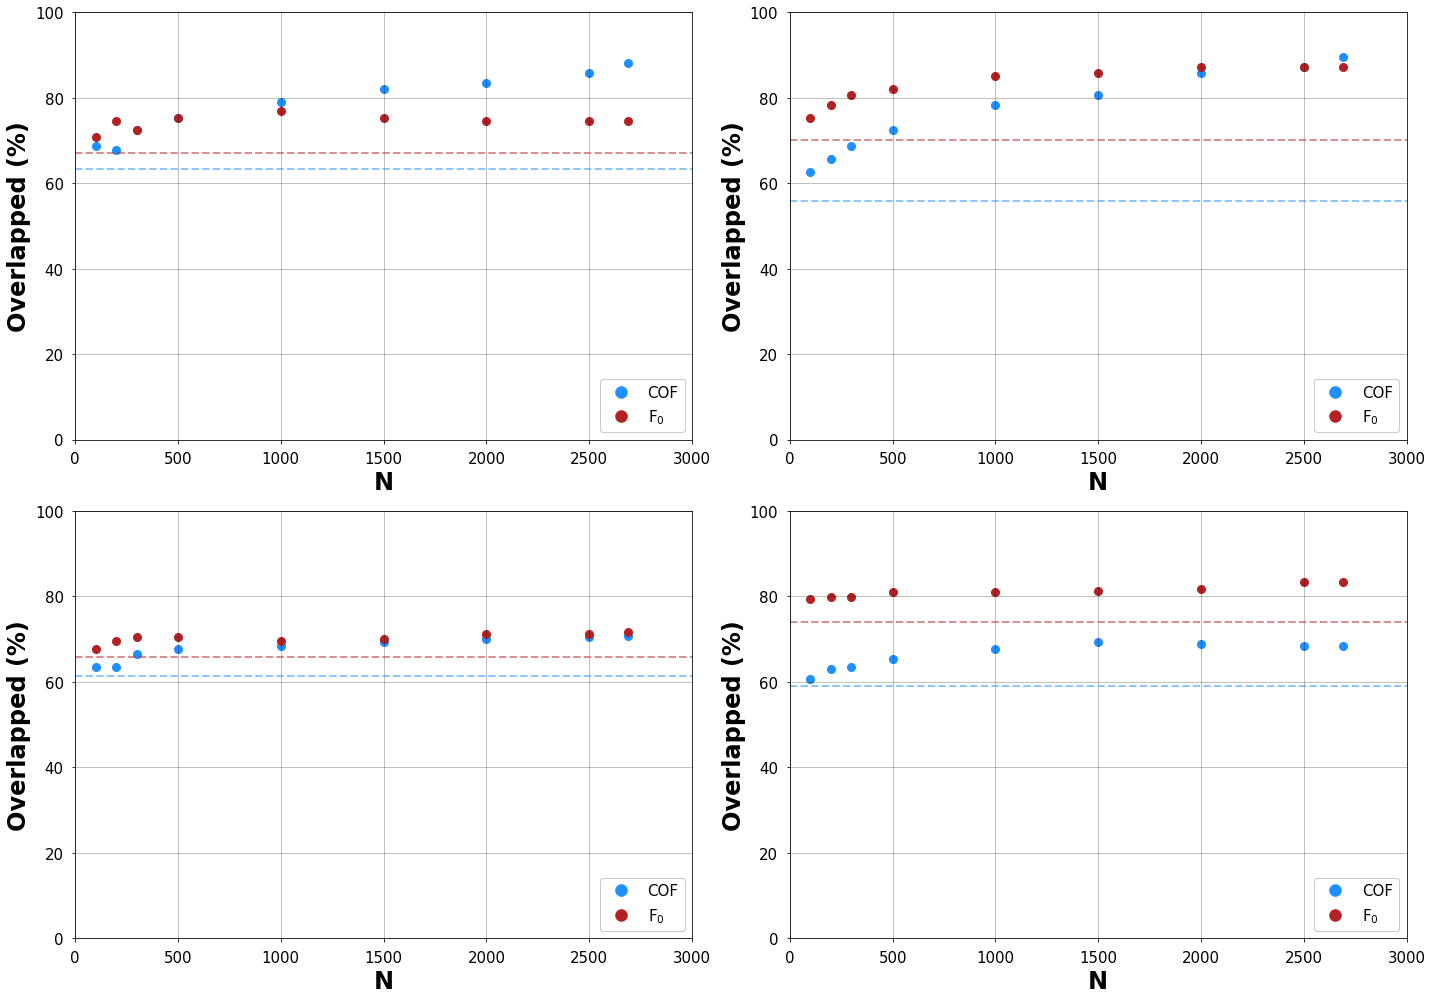

In [46]:
# Figure 1: Top 20% of t5050 with predicted by m50 and eve models 

n = 0.2
alpha=0.5

fig1, ax = plt.subplots(2, 2, figsize=(20, 14))


ax[0, 0].scatter(plot_data[f'top_{n}_5050']['m50']['COF']['point'], 
             plot_data[f'top_{n}_5050']['m50']['COF']['overlapped'],
             marker='o',
             color='dodgerblue',
             label='Mix-5050')

ax[0, 0].scatter(plot_data[f'top_{n}_5050']['m50']['intercept']['point'], 
             plot_data[f'top_{n}_5050']['m50']['intercept']['overlapped'],
             marker='o',
             color='firebrick',
             label='Mix-5050')

ax[1, 0].scatter(plot_data[f'top_{n}_2575']['m50']['COF']['point'], 
             plot_data[f'top_{n}_2575']['m50']['COF']['overlapped'],
             marker='o',
             color='dodgerblue',
             label='Mix-2575')

ax[1, 0].scatter(plot_data[f'top_{n}_2575']['m50']['intercept']['point'], 
             plot_data[f'top_{n}_2575']['m50']['intercept']['overlapped'],
             marker='o',
             color='firebrick',
             label='Mix-2575')

ax[0, 0].axhline(plot_data[f'top_{n}_5050']['og']['COF']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='dodgerblue',
            alpha=alpha,
            label='Mix-5050')
ax[0, 0].axhline(plot_data[f'top_{n}_5050']['og']['intercept']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='firebrick',
            alpha=alpha,
            label='Mix-5050')
ax[1, 0].axhline(plot_data[f'top_{n}_2575']['og']['COF']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='dodgerblue',
            alpha=alpha,
            label='Mix-2575')
ax[1, 0].axhline(plot_data[f'top_{n}_2575']['og']['intercept']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='firebrick',
            alpha=alpha,
            label='Mix-2575')

#ax.legend()
ax[0, 0].set_ylim(0, 100)
ax[0, 0].set_xlim(0, 3000)
ax[1, 0].set_ylim(0, 100)
ax[1, 0].set_xlim(0, 3000)

ax[0, 0].set_xlabel('N')
ax[0, 0].set_ylabel('Overlapped (%)')
ax[1, 0].set_xlabel('N')
ax[1, 0].set_ylabel('Overlapped (%)')
#ax1a.set_title(f'Top {n} COF of {tset} overlapped with {models}', size=24, weight='bold')
#ax1b.set_title(f'Top {n} F$_0$ of {tset} overlappped with {models}', size=24, weight='bold')
#plt.savefig(fname=f'./plots/top_and_bot/overlap_{models}_{tset}_top_{n}.pdf')

ax[0, 1].scatter(plot_data[f'bot_{n}_5050']['m50']['COF']['point'], 
             plot_data[f'bot_{n}_5050']['m50']['COF']['overlapped'],
             marker='o',
             color='dodgerblue',
             label='Mix-5050')


ax[0, 1].scatter(plot_data[f'bot_{n}_5050']['m50']['intercept']['point'], 
             plot_data[f'bot_{n}_5050']['m50']['intercept']['overlapped'],
             marker='o',
             color='firebrick',
             label='Mix-5050')


ax[1, 1].scatter(plot_data[f'bot_{n}_2575']['m50']['COF']['point'], 
             plot_data[f'bot_{n}_2575']['m50']['COF']['overlapped'],
             marker='o',
             color='dodgerblue',
             label='Mix-2575')

ax[1, 1].scatter(plot_data[f'bot_{n}_2575']['m50']['intercept']['point'], 
             plot_data[f'bot_{n}_2575']['m50']['intercept']['overlapped'],
             marker='o',
             color='firebrick',
             label='Mix-2575')
          
ax[0, 1].axhline(plot_data[f'bot_{n}_5050']['og']['COF']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='dodgerblue',
            alpha=alpha,
            label='Mix-5050')
ax[0, 1].axhline(plot_data[f'bot_{n}_5050']['og']['intercept']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='firebrick',
            alpha=alpha,
            label='Mix-5050')
ax[1, 1].axhline(plot_data[f'bot_{n}_2575']['og']['COF']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='dodgerblue',
            alpha=alpha,
            label='Mix-2575')
ax[1, 1].axhline(plot_data[f'bot_{n}_2575']['og']['intercept']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='firebrick',
            alpha=alpha,
            label='Mix-2575')       
ax[0, 1].set_ylim(0, 100)
ax[0, 1].set_xlim(0, 3000)
ax[1, 1].set_ylim(0, 100)
ax[1, 1].set_xlim(0, 3000)

ax[0, 1].set_xlabel('N')
ax[0, 1].set_ylabel('Overlapped (%)')
ax[1, 1].set_xlabel('N')
ax[1, 1].set_ylabel('Overlapped (%)')
#ax2a.set_title(f'Bottom {n} COF of {tset} overlapped with {models}', size=24, weight='bold')
#ax2b.set_title(f'Bottom {n} F$_0$ of {tset} overlapped with {models}', size=24, weight='bold')
#plt.savefig(fname=f'./plots/top_and_bot/overlap_{models}_{tset}_bot_{n}.pdf')

leg1_ele = [Line2D([0], [0], color='dodgerblue', marker='o', markersize=12, linestyle='', label='COF'),
                   Line2D([0], [0], color='firebrick', marker='o', markersize=12, linestyle='', label='F$_0$')]
#leg2_ele = [Line2D([0], [0], color='grey', marker='s', markersize=12, linestyle='', label='Mix-5050'),
#                   Line2D([0], [0], color='grey', marker='^', markersize=12, linestyle='', label='Mix-2575')]
                                  
#legend1a = ax[0, 0].legend(handles=leg1_ele, loc=3, title='Properties')
for i in [0, 1]:
    for j in [0, 1]:
        legend = ax[i, j].legend(handles=leg1_ele, loc=4)# title='Properties')
        ax[i, j].add_artist(legend)
#ax1a.add_artist(legend1a)

#legend1b = ax1b.legend(handles=leg1_ele, loc=3, title='Properties')
#legend2b = ax1b.legend(handles=leg2_ele, loc=4, title='Test sets')
#ax1b.add_artist(legend1b)

plt.savefig(fname=f'./plots/top_and_bot/overlap_{n}_tm_m50_v2.pdf', dpi=500, bbox_inches='tight')


plt.show()

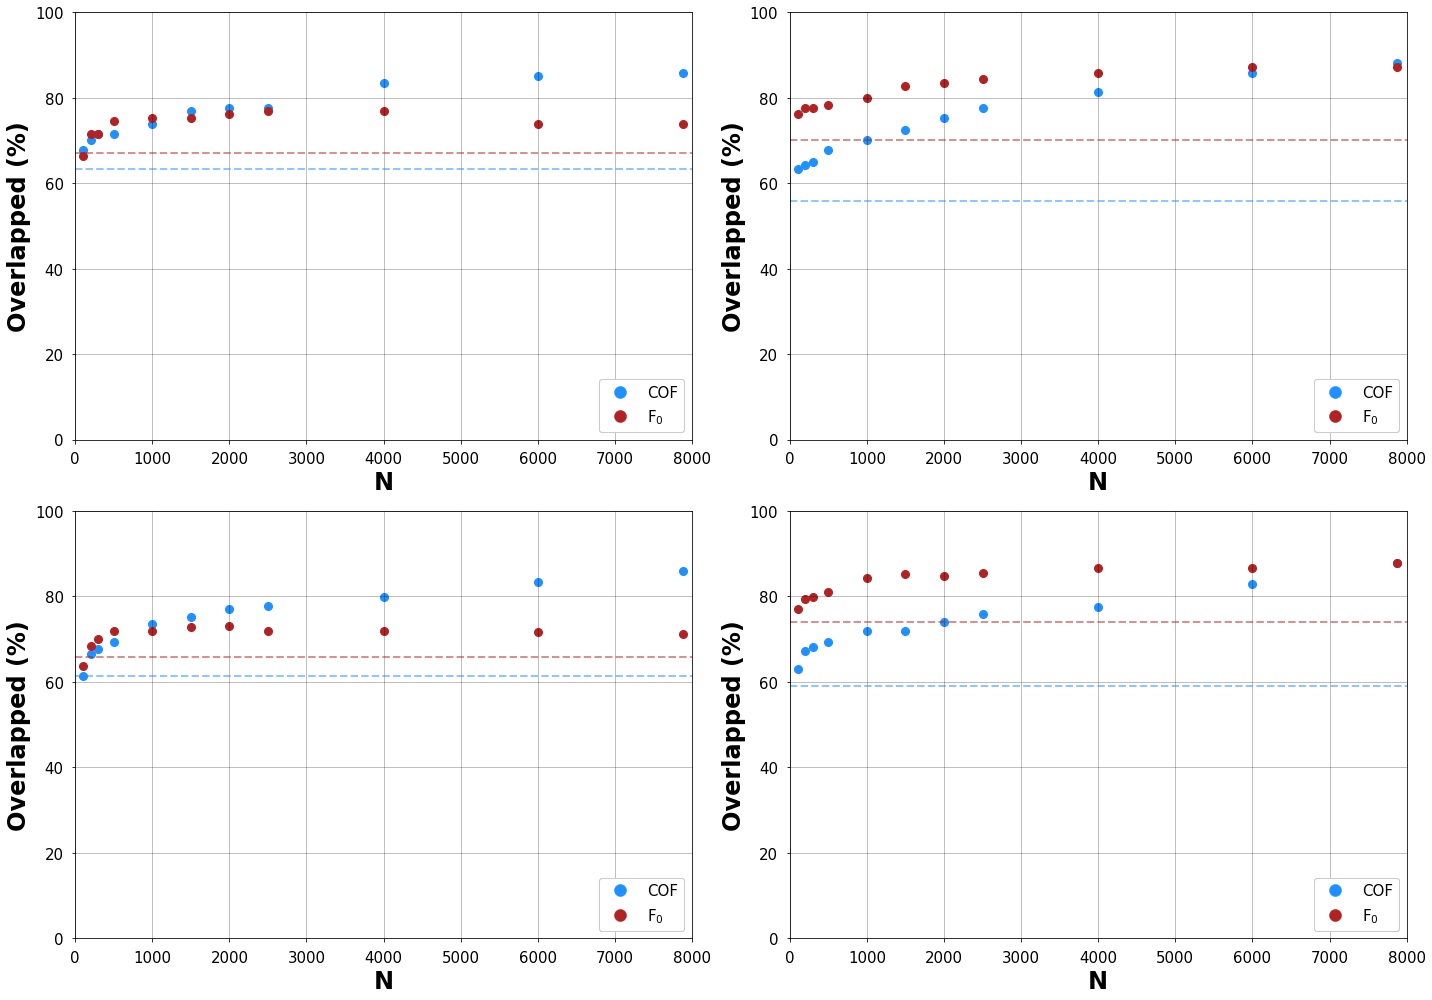

In [47]:
# Figure 1: Top 20% of t5050 and t2575 with predicted by eve models 

n = 0.2
alpha=0.5

fig1, ax = plt.subplots(2, 2, figsize=(20, 14))


ax[0, 0].scatter(plot_data[f'top_{n}_5050']['eve']['COF']['point'], 
             plot_data[f'top_{n}_5050']['eve']['COF']['overlapped'],
             marker='o',
             color='dodgerblue',
             label='Mix-5050')

ax[0, 0].scatter(plot_data[f'top_{n}_5050']['eve']['intercept']['point'], 
             plot_data[f'top_{n}_5050']['eve']['intercept']['overlapped'],
             marker='o',
             color='firebrick',
             label='Mix-5050')

ax[1, 0].scatter(plot_data[f'top_{n}_2575']['eve']['COF']['point'], 
             plot_data[f'top_{n}_2575']['eve']['COF']['overlapped'],
             marker='o',
             color='dodgerblue',
             label='Mix-2575')

ax[1, 0].scatter(plot_data[f'top_{n}_2575']['eve']['intercept']['point'], 
             plot_data[f'top_{n}_2575']['eve']['intercept']['overlapped'],
             marker='o',
             color='firebrick',
             label='Mix-2575')

ax[0, 0].axhline(plot_data[f'top_{n}_5050']['og']['COF']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='dodgerblue',
            alpha=alpha,
            label='Mix-5050')
ax[0, 0].axhline(plot_data[f'top_{n}_5050']['og']['intercept']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='firebrick',
            alpha=alpha,
            label='Mix-5050')
ax[1, 0].axhline(plot_data[f'top_{n}_2575']['og']['COF']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='dodgerblue',
            alpha=alpha,
            label='Mix-2575')
ax[1, 0].axhline(plot_data[f'top_{n}_2575']['og']['intercept']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='firebrick',
            alpha=alpha,
            label='Mix-2575')

#ax.legend()
ax[0, 0].set_ylim(0, 100)
ax[0, 0].set_xlim(0, 8000)
ax[1, 0].set_ylim(0, 100)
ax[1, 0].set_xlim(0, 8000)

ax[0, 0].set_xlabel('N')
ax[0, 0].set_ylabel('Overlapped (%)')
ax[1, 0].set_xlabel('N')
ax[1, 0].set_ylabel('Overlapped (%)')
#ax1a.set_title(f'Top {n} COF of {tset} overlapped with {models}', size=24, weight='bold')
#ax1b.set_title(f'Top {n} F$_0$ of {tset} overlappped with {models}', size=24, weight='bold')
#plt.savefig(fname=f'./plots/top_and_bot/overlap_{models}_{tset}_top_{n}.pdf')

ax[0, 1].scatter(plot_data[f'bot_{n}_5050']['eve']['COF']['point'], 
             plot_data[f'bot_{n}_5050']['eve']['COF']['overlapped'],
             marker='o',
             color='dodgerblue',
             label='Mix-5050')


ax[0, 1].scatter(plot_data[f'bot_{n}_5050']['eve']['intercept']['point'], 
             plot_data[f'bot_{n}_5050']['eve']['intercept']['overlapped'],
             marker='o',
             color='firebrick',
             label='Mix-5050')


ax[1, 1].scatter(plot_data[f'bot_{n}_2575']['eve']['COF']['point'], 
             plot_data[f'bot_{n}_2575']['eve']['COF']['overlapped'],
             marker='o',
             color='dodgerblue',
             label='Mix-2575')

ax[1, 1].scatter(plot_data[f'bot_{n}_2575']['eve']['intercept']['point'], 
             plot_data[f'bot_{n}_2575']['eve']['intercept']['overlapped'],
             marker='o',
             color='firebrick',
             label='Mix-2575')
          
ax[0, 1].axhline(plot_data[f'bot_{n}_5050']['og']['COF']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='dodgerblue',
            alpha=alpha,
            label='Mix-5050')
ax[0, 1].axhline(plot_data[f'bot_{n}_5050']['og']['intercept']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='firebrick',
            alpha=alpha,
            label='Mix-5050')
ax[1, 1].axhline(plot_data[f'bot_{n}_2575']['og']['COF']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='dodgerblue',
            alpha=alpha,
            label='Mix-2575')
ax[1, 1].axhline(plot_data[f'bot_{n}_2575']['og']['intercept']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='firebrick',
            alpha=alpha,
            label='Mix-2575')       
ax[0, 1].set_ylim(0, 100)
ax[0, 1].set_xlim(0, 8000)
ax[1, 1].set_ylim(0, 100)
ax[1, 1].set_xlim(0, 8000)

ax[0, 1].set_xlabel('N')
ax[0, 1].set_ylabel('Overlapped (%)')
ax[1, 1].set_xlabel('N')
ax[1, 1].set_ylabel('Overlapped (%)')
#ax2a.set_title(f'Bottom {n} COF of {tset} overlapped with {models}', size=24, weight='bold')
#ax2b.set_title(f'Bottom {n} F$_0$ of {tset} overlapped with {models}', size=24, weight='bold')
#plt.savefig(fname=f'./plots/top_and_bot/overlap_{models}_{tset}_bot_{n}.pdf')

leg1_ele = [Line2D([0], [0], color='dodgerblue', marker='o', markersize=12, linestyle='', label='COF'),
                   Line2D([0], [0], color='firebrick', marker='o', markersize=12, linestyle='', label='F$_0$')]
#leg2_ele = [Line2D([0], [0], color='grey', marker='s', markersize=12, linestyle='', label='Mix-5050'),
#                   Line2D([0], [0], color='grey', marker='^', markersize=12, linestyle='', label='Mix-2575')]
                                  

from copy import deepcopy
from copy import copy

#legend1a = ax[0, 0].legend(handles=leg1_ele, loc=3, title='Properties')
for i in [0, 1]:
    for j in [0, 1]:
        legend = ax[i, j].legend(handles=leg1_ele, loc=4)#, title='Properties')
        ax[i, j].add_artist(legend)
#ax1a.add_artist(legend1a)

#legend1b = ax1b.legend(handles=leg1_ele, loc=3, title='Properties')
#legend2b = ax1b.legend(handles=leg2_ele, loc=4, title='Test sets')
#ax1b.add_artist(legend1b)

#plt.savefig(fname=f'./plots/top_and_bot/overlap_{n}_tm_eve_v2.pdf', dpi=500, bbox_inches='tight')


plt.show()

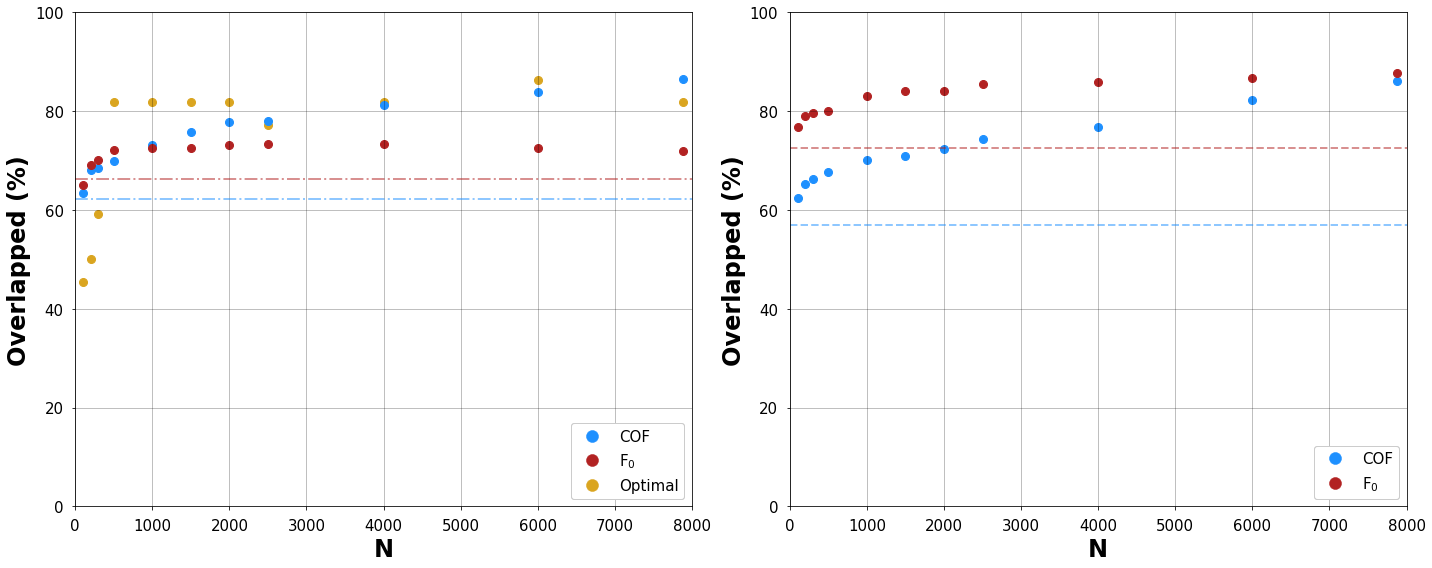

In [48]:
# Figure 1: Top 20% of eve with predicted by eve models 

n = 0.2
alpha=0.5

fig1, (ax1a, ax1b) = plt.subplots(1, 2, figsize=(20, 8))

ax1a.scatter(plot_data[f'top_{n}_everything']['eve']['point'], 
             plot_data[f'top_{n}_everything']['eve']['opt'],
             marker='o',
             color='goldenrod',
             label='everything')

ax1a.scatter(plot_data[f'top_{n}_everything']['eve']['COF']['point'], 
             plot_data[f'top_{n}_everything']['eve']['COF']['overlapped'],
             marker='o',
             color='dodgerblue',
             label='everything')

ax1a.scatter(plot_data[f'top_{n}_everything']['eve']['intercept']['point'], 
             plot_data[f'top_{n}_everything']['eve']['intercept']['overlapped'],
             marker='o',
             color='firebrick',
             label='everything')

# ax1a.scatter(plot_data[f'top_{n}_2575']['eve']['COF']['point'], 
#              plot_data[f'top_{n}_2575']['eve']['COF']['overlapped'],
#              marker='^',
#              color='dodgerblue',
#              label='Mix-2575')

# ax1a.scatter(plot_data[f'top_{n}_2575']['eve']['intercept']['point'], 
#              plot_data[f'top_{n}_2575']['eve']['intercept']['overlapped'],
#              marker='^',
#              color='firebrick',
#              label='Mix-2575')
ax1a.axhline(plot_data[f'top_{n}_everything']['og']['COF']['overlapped'],
            linestyle='-.',
            linewidth=2,
            color='dodgerblue',
            alpha=alpha,
            label='everything')
ax1a.axhline(plot_data[f'top_{n}_everything']['og']['intercept']['overlapped'],
            linestyle='-.',
            linewidth=2,
            color='firebrick',
            alpha=alpha,
            label='everything')

ax1a.legend()
ax1a.set_ylim(0, 100)
ax1a.set_xlim(0, 8000)

ax1a.set_xlabel('N')
ax1a.set_ylabel('Overlapped (%)')
#ax1a.set_title(f'Top {n} COF of {tset} overlapped with {models}', size=24, weight='bold')
#ax1b.set_title(f'Top {n} F$_0$ of {tset} overlappped with {models}', size=24, weight='bold')
#plt.savefig(fname=f'./plots/top_and_bot/overlap_{models}_{tset}_top_{n}.pdf')

ax1b.scatter(plot_data[f'bot_{n}_everything']['eve']['COF']['point'], 
             plot_data[f'bot_{n}_everything']['eve']['COF']['overlapped'],
             marker='o',
             color='dodgerblue',
             label='everything')


ax1b.scatter(plot_data[f'bot_{n}_everything']['eve']['intercept']['point'], 
             plot_data[f'bot_{n}_everything']['eve']['intercept']['overlapped'],
             marker='o',
             color='firebrick',
             label='everything')


# ax1b.scatter(plot_data[f'bot_{n}_2575']['eve']['COF']['point'], 
#              plot_data[f'bot_{n}_2575']['eve']['COF']['overlapped'],
#              marker='^',
#              color='dodgerblue',
#              label='Mix-2575')

# ax1b.scatter(plot_data[f'bot_{n}_2575']['eve']['intercept']['point'], 
#              plot_data[f'bot_{n}_2575']['eve']['intercept']['overlapped'],
#              marker='^',
#              color='firebrick',
#              label='Mix-2575')
ax1b.axhline(plot_data[f'bot_{n}_everything']['og']['COF']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='dodgerblue',
            alpha=alpha,
            label='everything')
ax1b.axhline(plot_data[f'bot_{n}_everything']['og']['intercept']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='firebrick',
            alpha=alpha,
            label='everything')          

ax1b.set_ylim(0, 100)
ax1b.set_xlim(0, 8000)

ax1b.set_xlabel('N')
ax1b.set_ylabel('Overlapped (%)')
#ax2a.set_title(f'Bottom {n} COF of {tset} overlapped with {models}', size=24, weight='bold')
#ax2b.set_title(f'Bottom {n} F$_0$ of {tset} overlapped with {models}', size=24, weight='bold')
#plt.savefig(fname=f'./plots/top_and_bot/overlap_{models}_{tset}_bot_{n}.pdf')

leg1_ele = [Line2D([0], [0], color='dodgerblue', marker='o', markersize=12, linestyle='', label='COF'),
            Line2D([0], [0], color='firebrick', marker='o', markersize=12, linestyle='', label='F$_0$'),
            Line2D([0], [0], color='goldenrod', marker='o', markersize=12, linestyle='', label='Optimal')]
leg2_ele = [Line2D([0], [0], color='dodgerblue', marker='o', markersize=12, linestyle='', label='COF'),
            Line2D([0], [0], color='firebrick', marker='o', markersize=12, linestyle='', label='F$_0$')]
#leg2_ele = [Line2D([0], [0], color='grey', marker='s', markersize=12, linestyle='', label='Mix-5050'),
#                   Line2D([0], [0], color='grey', marker='^', markersize=12, linestyle='', label='Mix-2575')]
                                  

legend1a = ax1a.legend(handles=leg1_ele, loc=4)#, title='Properties')
#legend2a = ax1a.legend(handles=leg2_ele, loc=4, title='Test sets')
ax1a.add_artist(legend1a)

legend1b = ax1b.legend(handles=leg2_ele, loc=4)#, title='Properties')
#legend2b = ax1b.legend(handles=leg2_ele, loc=4, title='Test sets')
ax1b.add_artist(legend1b)

plt.savefig(fname=f'./plots/top_and_bot/overlap_{n}_teve_eve.pdf', dpi=500, bbox_inches='tight')


plt.show()

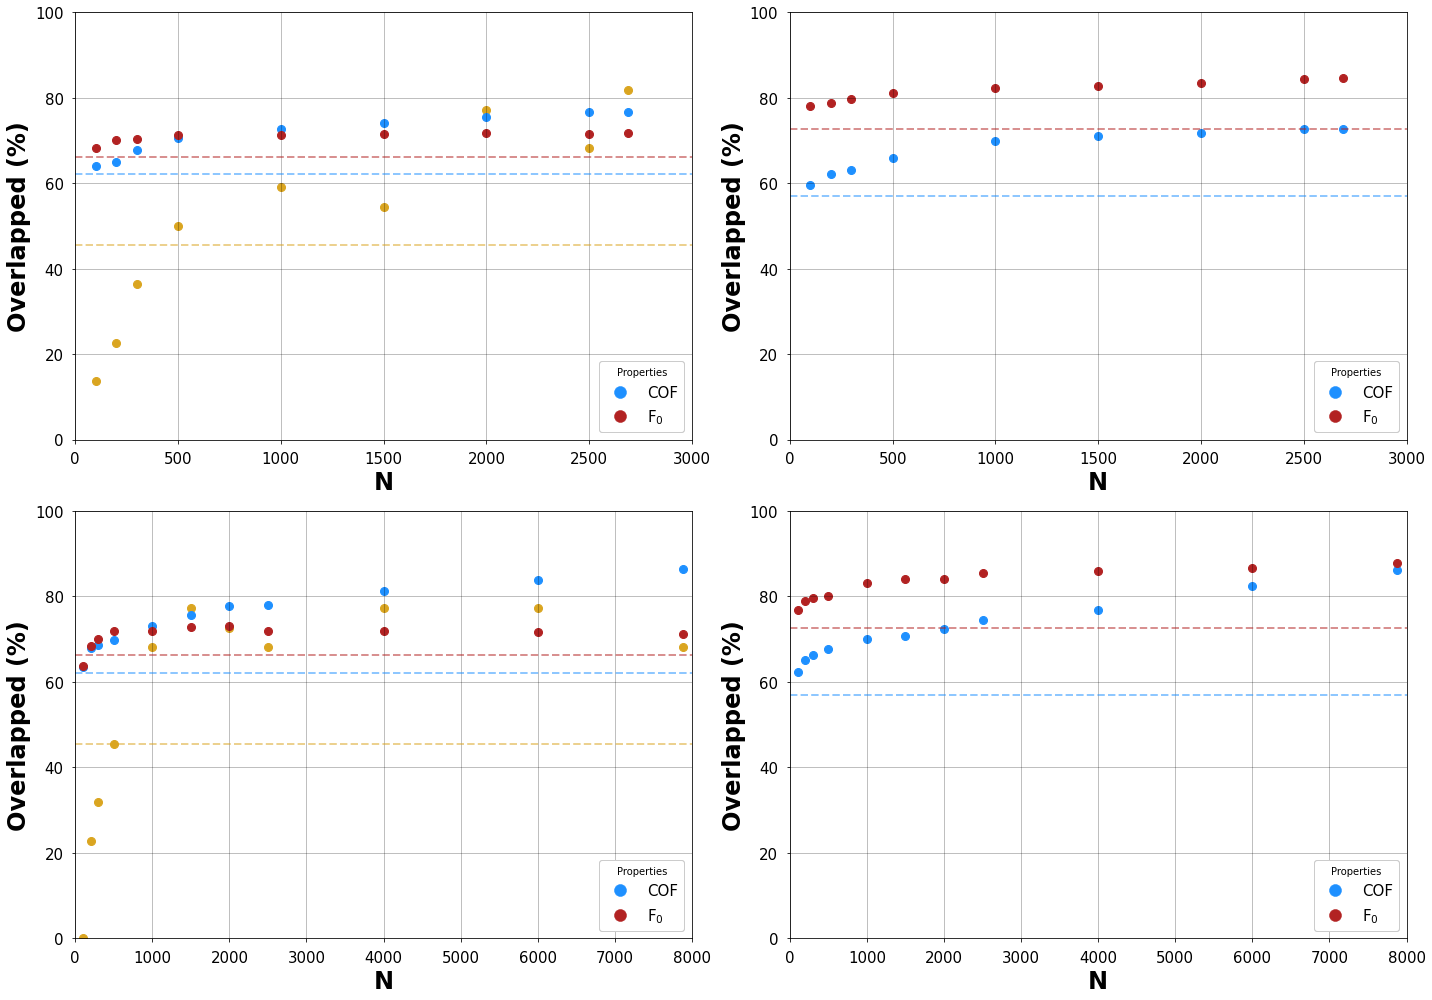

In [33]:
# Figure 1: Top 20% of total-test with predicted by m50 and eve models 

n = 0.2
alpha=0.5

fig1, ax = plt.subplots(2, 2, figsize=(20, 14))

ax[0, 0].scatter(plot_data[f'top_{n}_everything']['m50']['point'], 
             plot_data[f'top_{n}_everything']['m50']['opt'],
             marker='o',
             color='goldenrod',
             label='opt')

ax[1, 0].scatter(plot_data[f'top_{n}_everything']['eve']['point'], 
             plot_data[f'top_{n}_everything']['eve']['opt'],
             marker='o',
             color='goldenrod',
             label='opt')

ax[0, 0].scatter(plot_data[f'top_{n}_everything']['m50']['COF']['point'], 
             plot_data[f'top_{n}_everything']['m50']['COF']['overlapped'],
             marker='o',
             color='dodgerblue',
             label='m50')

ax[0, 0].scatter(plot_data[f'top_{n}_everything']['m50']['intercept']['point'], 
             plot_data[f'top_{n}_everything']['m50']['intercept']['overlapped'],
             marker='o',
             color='firebrick',
             label='m50')

ax[1, 0].scatter(plot_data[f'top_{n}_everything']['eve']['COF']['point'], 
             plot_data[f'top_{n}_everything']['eve']['COF']['overlapped'],
             marker='o',
             color='dodgerblue',
             label='eve')

ax[1, 0].scatter(plot_data[f'top_{n}_everything']['eve']['intercept']['point'], 
             plot_data[f'top_{n}_2575']['eve']['intercept']['overlapped'],
             marker='o',
             color='firebrick',
             label='eve')

ax[0, 0].axhline(plot_data[f'top_{n}_everything']['og']['opt'],
            linestyle='--',
            linewidth=2,
            color='goldenrod',
            alpha=alpha,
            label='og')
ax[0, 0].axhline(plot_data[f'top_{n}_everything']['og']['COF']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='dodgerblue',
            alpha=alpha,
            label='Mix-5050')
ax[0, 0].axhline(plot_data[f'top_{n}_everything']['og']['intercept']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='firebrick',
            alpha=alpha,
            label='Mix-5050')
                                                               
ax[1, 0].axhline(plot_data[f'top_{n}_everything']['og']['opt'],
            linestyle='--',
            linewidth=2,
            color='goldenrod',
            alpha=alpha,
            label='og')
ax[1, 0].axhline(plot_data[f'top_{n}_everything']['og']['COF']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='dodgerblue',
            alpha=alpha,
            label='Mix-2575')
ax[1, 0].axhline(plot_data[f'top_{n}_everything']['og']['intercept']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='firebrick',
            alpha=alpha,
            label='Mix-2575')

#ax.legend()
ax[0, 0].set_ylim(0, 100)
ax[0, 0].set_xlim(0, 3000)
ax[1, 0].set_ylim(0, 100)
ax[1, 0].set_xlim(0, 8000)

ax[0, 0].set_xlabel('N')
ax[0, 0].set_ylabel('Overlapped (%)')
ax[1, 0].set_xlabel('N')
ax[1, 0].set_ylabel('Overlapped (%)')
#ax1a.set_title(f'Top {n} COF of {tset} overlapped with {models}', size=24, weight='bold')
#ax1b.set_title(f'Top {n} F$_0$ of {tset} overlappped with {models}', size=24, weight='bold')
#plt.savefig(fname=f'./plots/top_and_bot/overlap_{models}_{tset}_top_{n}.pdf')

ax[0, 1].scatter(plot_data[f'bot_{n}_everything']['m50']['COF']['point'], 
             plot_data[f'bot_{n}_everything']['m50']['COF']['overlapped'],
             marker='o',
             color='dodgerblue',
             label='m50')


ax[0, 1].scatter(plot_data[f'bot_{n}_everything']['m50']['intercept']['point'], 
             plot_data[f'bot_{n}_everything']['m50']['intercept']['overlapped'],
             marker='o',
             color='firebrick',
             label='m50')


ax[1, 1].scatter(plot_data[f'bot_{n}_everything']['eve']['COF']['point'], 
             plot_data[f'bot_{n}_everything']['eve']['COF']['overlapped'],
             marker='o',
             color='dodgerblue',
             label='eve')

ax[1, 1].scatter(plot_data[f'bot_{n}_everything']['eve']['intercept']['point'], 
             plot_data[f'bot_{n}_everything']['eve']['intercept']['overlapped'],
             marker='o',
             color='firebrick',
             label='eve')
          
ax[0, 1].axhline(plot_data[f'bot_{n}_everything']['og']['COF']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='dodgerblue',
            alpha=alpha,
            label='og')
ax[0, 1].axhline(plot_data[f'bot_{n}_everything']['og']['intercept']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='firebrick',
            alpha=alpha,
            label='og')
ax[1, 1].axhline(plot_data[f'bot_{n}_everything']['og']['COF']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='dodgerblue',
            alpha=alpha,
            label='og')
ax[1, 1].axhline(plot_data[f'bot_{n}_everything']['og']['intercept']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='firebrick',
            alpha=alpha,
            label='og')       
ax[0, 1].set_ylim(0, 100)
ax[0, 1].set_xlim(0, 3000)
ax[1, 1].set_ylim(0, 100)
ax[1, 1].set_xlim(0, 8000)

ax[0, 1].set_xlabel('N')
ax[0, 1].set_ylabel('Overlapped (%)')
ax[1, 1].set_xlabel('N')
ax[1, 1].set_ylabel('Overlapped (%)')
#ax2a.set_title(f'Bottom {n} COF of {tset} overlapped with {models}', size=24, weight='bold')
#ax2b.set_title(f'Bottom {n} F$_0$ of {tset} overlapped with {models}', size=24, weight='bold')
#plt.savefig(fname=f'./plots/top_and_bot/overlap_{models}_{tset}_bot_{n}.pdf')

leg1_ele = [Line2D([0], [0], color='dodgerblue', marker='o', markersize=12, linestyle='', label='COF'),
                   Line2D([0], [0], color='firebrick', marker='o', markersize=12, linestyle='', label='F$_0$')]
#leg2_ele = [Line2D([0], [0], color='grey', marker='s', markersize=12, linestyle='', label='Mix-5050'),
#                   Line2D([0], [0], color='grey', marker='^', markersize=12, linestyle='', label='Mix-2575')]
                                  

from copy import deepcopy
from copy import copy

#legend1a = ax[0, 0].legend(handles=leg1_ele, loc=3, title='Properties')
for i in [0, 1]:
    for j in [0, 1]:
        legend = ax[i, j].legend(handles=leg1_ele, loc=4, title='Properties')
        ax[i, j].add_artist(legend)
#ax1a.add_artist(legend1a)

#legend1b = ax1b.legend(handles=leg1_ele, loc=3, title='Properties')
#legend2b = ax1b.legend(handles=leg2_ele, loc=4, title='Test sets')
#ax1b.add_artist(legend1b)

plt.savefig(fname=f'./plots/top_and_bot/overlap_{n}_teve_v2.pdf', dpi=500, bbox_inches='tight')


plt.show()

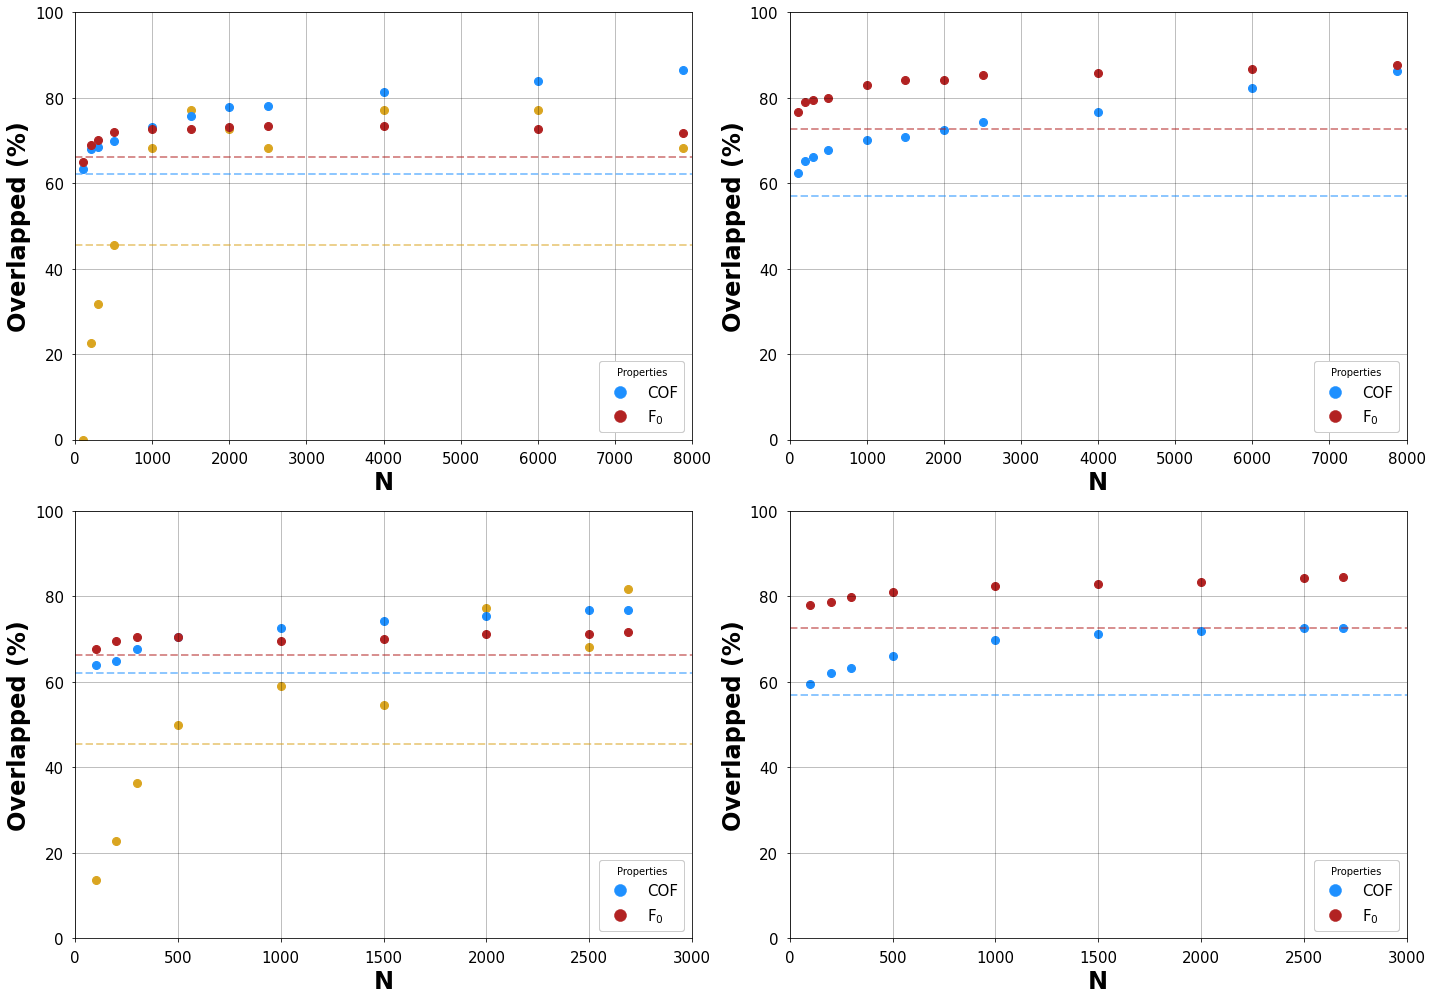

In [35]:
# Figure 1: Top 20% of total-test with predicted by m50 and eve models 

n = 0.2
alpha=0.5

fig1, ax = plt.subplots(2, 2, figsize=(20, 14))

ax[0, 0].scatter(plot_data[f'top_{n}_everything']['eve']['point'], 
             plot_data[f'top_{n}_everything']['eve']['opt'],
             marker='o',
             color='goldenrod',
             label='opt')

ax[1, 0].scatter(plot_data[f'top_{n}_everything']['m50']['point'], 
             plot_data[f'top_{n}_everything']['m50']['opt'],
             marker='o',
             color='goldenrod',
             label='opt')

ax[0, 0].scatter(plot_data[f'top_{n}_everything']['eve']['COF']['point'], 
             plot_data[f'top_{n}_everything']['eve']['COF']['overlapped'],
             marker='o',
             color='dodgerblue',
             label='m50')

ax[0, 0].scatter(plot_data[f'top_{n}_everything']['eve']['intercept']['point'], 
             plot_data[f'top_{n}_everything']['eve']['intercept']['overlapped'],
             marker='o',
             color='firebrick',
             label='m50')

ax[1, 0].scatter(plot_data[f'top_{n}_everything']['m50']['COF']['point'], 
             plot_data[f'top_{n}_everything']['m50']['COF']['overlapped'],
             marker='o',
             color='dodgerblue',
             label='eve')

ax[1, 0].scatter(plot_data[f'top_{n}_everything']['m50']['intercept']['point'], 
             plot_data[f'top_{n}_2575']['m50']['intercept']['overlapped'],
             marker='o',
             color='firebrick',
             label='eve')

ax[0, 0].axhline(plot_data[f'top_{n}_everything']['og']['opt'],
            linestyle='--',
            linewidth=2,
            color='goldenrod',
            alpha=alpha,
            label='og')
ax[0, 0].axhline(plot_data[f'top_{n}_everything']['og']['COF']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='dodgerblue',
            alpha=alpha,
            label='Mix-5050')
ax[0, 0].axhline(plot_data[f'top_{n}_everything']['og']['intercept']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='firebrick',
            alpha=alpha,
            label='Mix-5050')
                                                               
ax[1, 0].axhline(plot_data[f'top_{n}_everything']['og']['opt'],
            linestyle='--',
            linewidth=2,
            color='goldenrod',
            alpha=alpha,
            label='og')
ax[1, 0].axhline(plot_data[f'top_{n}_everything']['og']['COF']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='dodgerblue',
            alpha=alpha,
            label='Mix-2575')
ax[1, 0].axhline(plot_data[f'top_{n}_everything']['og']['intercept']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='firebrick',
            alpha=alpha,
            label='Mix-2575')

#ax.legend()
ax[0, 0].set_ylim(0, 100)
ax[0, 0].set_xlim(0, 8000)
ax[1, 0].set_ylim(0, 100)
ax[1, 0].set_xlim(0, 3000)

ax[0, 0].set_xlabel('N')
ax[0, 0].set_ylabel('Overlapped (%)')
ax[1, 0].set_xlabel('N')
ax[1, 0].set_ylabel('Overlapped (%)')
#ax1a.set_title(f'Top {n} COF of {tset} overlapped with {models}', size=24, weight='bold')
#ax1b.set_title(f'Top {n} F$_0$ of {tset} overlappped with {models}', size=24, weight='bold')
#plt.savefig(fname=f'./plots/top_and_bot/overlap_{models}_{tset}_top_{n}.pdf')

ax[0, 1].scatter(plot_data[f'bot_{n}_everything']['eve']['COF']['point'], 
             plot_data[f'bot_{n}_everything']['eve']['COF']['overlapped'],
             marker='o',
             color='dodgerblue',
             label='m50')


ax[0, 1].scatter(plot_data[f'bot_{n}_everything']['eve']['intercept']['point'], 
             plot_data[f'bot_{n}_everything']['eve']['intercept']['overlapped'],
             marker='o',
             color='firebrick',
             label='m50')


ax[1, 1].scatter(plot_data[f'bot_{n}_everything']['m50']['COF']['point'], 
             plot_data[f'bot_{n}_everything']['m50']['COF']['overlapped'],
             marker='o',
             color='dodgerblue',
             label='eve')

ax[1, 1].scatter(plot_data[f'bot_{n}_everything']['m50']['intercept']['point'], 
             plot_data[f'bot_{n}_everything']['m50']['intercept']['overlapped'],
             marker='o',
             color='firebrick',
             label='eve')
          
ax[0, 1].axhline(plot_data[f'bot_{n}_everything']['og']['COF']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='dodgerblue',
            alpha=alpha,
            label='og')
ax[0, 1].axhline(plot_data[f'bot_{n}_everything']['og']['intercept']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='firebrick',
            alpha=alpha,
            label='og')
ax[1, 1].axhline(plot_data[f'bot_{n}_everything']['og']['COF']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='dodgerblue',
            alpha=alpha,
            label='og')
ax[1, 1].axhline(plot_data[f'bot_{n}_everything']['og']['intercept']['overlapped'],
            linestyle='--',
            linewidth=2,
            color='firebrick',
            alpha=alpha,
            label='og')       
ax[0, 1].set_ylim(0, 100)
ax[0, 1].set_xlim(0, 8000)
ax[1, 1].set_ylim(0, 100)
ax[1, 1].set_xlim(0, 3000)

ax[0, 1].set_xlabel('N')
ax[0, 1].set_ylabel('Overlapped (%)')
ax[1, 1].set_xlabel('N')
ax[1, 1].set_ylabel('Overlapped (%)')
#ax2a.set_title(f'Bottom {n} COF of {tset} overlapped with {models}', size=24, weight='bold')
#ax2b.set_title(f'Bottom {n} F$_0$ of {tset} overlapped with {models}', size=24, weight='bold')
#plt.savefig(fname=f'./plots/top_and_bot/overlap_{models}_{tset}_bot_{n}.pdf')

leg1_ele = [Line2D([0], [0], color='dodgerblue', marker='o', markersize=12, linestyle='', label='COF'),
                   Line2D([0], [0], color='firebrick', marker='o', markersize=12, linestyle='', label='F$_0$')]
#leg2_ele = [Line2D([0], [0], color='grey', marker='s', markersize=12, linestyle='', label='Mix-5050'),
#                   Line2D([0], [0], color='grey', marker='^', markersize=12, linestyle='', label='Mix-2575')]
                                  

from copy import deepcopy
from copy import copy

#legend1a = ax[0, 0].legend(handles=leg1_ele, loc=3, title='Properties')
for i in [0, 1]:
    for j in [0, 1]:
        legend = ax[i, j].legend(handles=leg1_ele, loc=4, title='Properties')
        ax[i, j].add_artist(legend)
#ax1a.add_artist(legend1a)

#legend1b = ax1b.legend(handles=leg1_ele, loc=3, title='Properties')
#legend2b = ax1b.legend(handles=leg2_ele, loc=4, title='Test sets')
#ax1b.add_artist(legend1b)

plt.savefig(fname=f'./plots/top_and_bot/overlap_{n}_teve_v2.pdf', dpi=500, bbox_inches='tight')


plt.show()

In [50]:
plt.close()